In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import shutil
import os

source_path = os.path.join(taruntiwarihp_phishing_site_urls_path, 'phishing_site_urls.csv')

destination_path = './phishing_site_urls.csv'

shutil.copyfile(source_path, destination_path)

print(f"Data saved to: {destination_path}")

In [ ]:
! pip install eli5

In [ ]:
import pandas as pd
import numpy as np
import random
import sys
import os
!pip install tldextract -q
import tldextract
import warnings
import regex as re
import eli5
from typing import *

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from nltk.tokenize import RegexpTokenizer

warnings.filterwarnings("ignore")

In [ ]:
url_data = pd.read_csv('phishing_site_urls.csv')

#pd.set_option('display.max_colwidth', -1)
url_data.sample(10)

In [ ]:
url_data.info()
url_data.head()
url_data['Label'].value_counts()

# EDA & Preprocessing

To extract useful features from the URL, we first will break it down into useful parts using the urlparse method. This returns a dictionary of values of the url which will be added as columns in the dataframe soon.

In [ ]:
def parse_url(url: str) -> Optional[Dict[str, str]]:
    """
    Parse a given URL string into its components using urlparse.

    If the input URL does not start with a scheme (e.g., "http://" or "https://"),
    it assumes "http://" as the default scheme for parsing purposes. In such cases,
    the returned 'scheme' field will be set to None to indicate that the original URL
    did not explicitly include it.

    Args:
        url (str): The URL string to parse.

    Returns:
        Optional[Dict[str, str]]: A dictionary containing the following keys:
            - 'scheme' (str or None): The URL scheme specifier (e.g., 'http', 'https').
            - 'netloc' (str): The network location part (e.g., 'example.com').
            - 'path' (str): The hierarchical path (e.g., '/index.html').
            - 'params' (str): Parameters for last path element (rarely used).
            - 'query' (str): The query string (e.g., 'id=123').
            - 'fragment' (str): The fragment identifier (e.g., 'section1').
        Returns None if the URL cannot be parsed.
    """
    try:
        no_scheme = not url.startswith('https://') and not url.startswith('http://')
        if no_scheme:
            parsed_url = urlparse(f"http://{url}")
            return {
                "scheme": None,  # Not provided in the original URL
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
        else:
            parsed_url = urlparse(url)
            return {
                "scheme": parsed_url.scheme,
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
    except:
        return None

In [ ]:
print(url_data.columns)
print("Current columns:", url_data.columns.tolist())
url_data = url_data.rename(columns={"URL": "url", "Label": "label"})
url_data['label'] = url_data['label'].map({'good': 0, 'bad': 1})
url_data["parsed_url"] = url_data["url"].apply(parse_url)

Index(['URL', 'Label'], dtype='object')
Current columns: ['URL', 'Label']


In [ ]:
url_data = pd.concat([
    url_data.drop(['parsed_url'], axis=1),
    url_data['parsed_url'].apply(pd.Series)
], axis=1)
url_data

An initial problem faced was that urlparse would not parse some unreadable URLs. The following removes any column where the netloc has no value (ie when the parse_url method returns None).

In [ ]:
url_data = url_data.loc[:, ~url_data.columns.duplicated()]
url_data = url_data[~url_data.netloc.isnull()]

The first meaningful bit of data to extract is the length of the URL.

In [ ]:
url_data["length"] = url_data.url.str.len()

The TLD is then extracted using a python library, and if no TLD is present simply add 'None'.

In [ ]:
url_data["tld"] = url_data.netloc.apply(lambda nl: tldextract.extract(nl).suffix)
url_data['tld'] = url_data['tld'].replace('','None')

Next is a regex to determine if the URL is an IP address.

In [ ]:
url_data["is_ip"] = url_data.netloc.str.fullmatch(r"\d+\.\d+\.\d+\.\d+")

The next few sections relate to certain punctuation in the URL which may be an indicator one way or another that a URL is malicious. My reasoning behind this is that typosquatted domains (which are almost always malicious) may contain this punctation to appear similar to a legitimate domain. There may also be more of each in the path of the URL for a legitimate URL as blogs often use underscores in a URL.

In [ ]:
url_data['domain_hyphens'] = url_data.netloc.str.count('-')
url_data['domain_underscores'] = url_data.netloc.str.count('_')
url_data['path_hyphens'] = url_data.path.str.count('-')
url_data['path_underscores'] = url_data.path.str.count('_')
url_data['slashes'] = url_data.path.str.count('/')

Full stops in the path could indicate that theres an attempt to fool a user into thinking a domain is legit. For example, attacker.com/paypal.com may be used to trick a user. Full stops may also be a sign of files in the URL such as shell.exe

In [ ]:
url_data['full_stops'] = url_data.path.str.count('.')

Similar to the previous datapoint, getting the full stops in a subdomain will count how many subdomains are present. Lots may be another visual trick such as paypal.com.attacker.com/

In [ ]:
def get_num_subdomains(netloc: str) -> int:
    subdomain = tldextract.extract(netloc).subdomain
    if subdomain == "":
        return 0
    return subdomain.count('.') + 1

url_data['num_subdomains'] = url_data['netloc'].apply(lambda net: get_num_subdomains(net))

The lexical features of the URL will be important. In this instance, I have decided to separate the tokens from the path and the domain itself. My thinking here is that the same word in a path and domain may have very different meanings. By this i mean if you see 'paypal' in a URL path, it may be a malicious URL which is trying to seem legitimate, but 'paypal' in the domain may be more legitimate.

In [ ]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
def tokenize_domain(netloc: str) -> str:
    split_domain = tldextract.extract(netloc)
    no_tld = str(split_domain.subdomain +'.'+ split_domain.domain)
    return " ".join(map(str,tokenizer.tokenize(no_tld)))

url_data['domain_tokens'] = url_data['netloc'].apply(lambda net: tokenize_domain(net))

In [ ]:
url_data['path_tokens'] = url_data['path'].apply(lambda path: " ".join(map(str,tokenizer.tokenize(path))))

The labels are now extracted and the URL column removed.

In [ ]:
url_data_y = url_data['label']
url_data.drop('label', axis=1, inplace=True)
url_data.drop('url', axis=1, inplace=True)
url_data.drop('scheme', axis=1, inplace=True)
url_data.drop('netloc', axis=1, inplace=True)
url_data.drop('path', axis=1, inplace=True)
url_data.drop('params', axis=1, inplace=True)
url_data.drop('query', axis=1, inplace=True)
url_data.drop('fragment', axis=1, inplace=True)

In [ ]:
url_data.info()
print(url_data.sample(5))

These features are designed to capture structural, lexical, and linguistic patterns that commonly appear in malicious URLs.

---

Numerical Features

| Feature Name       | Description |
|--------------------|-------------|
| `length`           | Total length of the URL (number of characters). Longer URLs are often used to obfuscate malicious content. |
| `slashes`          | Number of slashes (`/`) in the URL path, indicating the depth or nesting level. |
| `full_stops`       | Number of full stops (`.`) in the URL path, which can indicate multiple fake file extensions or complex routing. |
| `domain_hyphens`   | Count of hyphens (`-`) in the domain/subdomain part of the URL. Multiple hyphens are often a red flag. |
| `domain_underscores` | Count of underscores (`_`) in the domain/subdomain. While technically valid, underscores are rarely used in real domains. |
| `path_hyphens`     | Number of hyphens in the URL path. Often used to mimic legitimate resource names. |
| `path_underscores` | Number of underscores in the path. Excessive underscores may indicate suspicious formatting. |
| `num_subdomains`   | Number of subdomain levels. Phishing sites often mimic trusted domains using deep subdomain structures. |

---

Categorical Features

| Feature Name | Description |
|--------------|-------------|
| `tld`        | Top-level domain (e.g., `com`, `org`, `info`). Certain uncommon or free TLDs are more frequently associated with phishing. |

---

Boolean Features

| Feature Name | Description |
|--------------|-------------|
| `is_ip`      | Indicates whether the domain is an IP address (`true`) or a named domain (`false`). IP-based URLs are common in phishing. |

---

Text Features

| Feature Name     | Description |
|------------------|-------------|
| `domain_tokens`  | Extracted alphabetic words from the domain and subdomain (excluding the TLD). These tokens may contain suspicious keywords such as `login`, `secure`, `verify`, etc. |
| `path_tokens`    | Extracted alphabetic tokens from the URL path. Phishing URLs often contain words like `account`, `update`, `submit`, `login`, and `verify`. |

---


In [ ]:
url_data_all = url_data.copy()
url_data_all['label'] = url_data_y

url_data_all.to_csv('processed_url_data.csv', index=False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=url_data_all, x='label')
plt.xticks([0, 1], ['Good (0)', 'Phishing (1)'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Training

When using pipelines and vectorizers, you need a converter to feed the vectorizer every word of that column. It cannot add the values one row at a time and so a converter class must be created.

In [ ]:
class Converter(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, data_frame):
        return data_frame.values.ravel()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(url_data, url_data_y, test_size=0.2)

The numeric features need their own pipeline to scale the data, MinMaxScaler was used as MultinomialNB needs no negative values to work.

In [ ]:
numeric_features = ['length', 'domain_hyphens', 'domain_underscores', 'path_hyphens', 'path_underscores', 'slashes', 'full_stops', 'num_subdomains']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

The only categorical feature is TLD and OneHot encoding will be used for this. Interestingly there is no difference between using this or converting and using the TfidfVectorizer. However, using OneHot encoding makes the TLD obvious in the feature importance section.

In [ ]:
categorical_features = ['tld', 'is_ip']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

CountVectorizer and TfidfVectorizer produce very similar results, but with the best performing model (spoiler its SVC) Tfidf slightly improved the score.

In [ ]:
vectorizer_features = ['domain_tokens','path_tokens']
vectorizer_transformer = Pipeline(steps=[
    ('con', Converter()),
    ('tf', TfidfVectorizer())])

The next step is to link all the transformers together in a ColumnTransformer, and create a pipeline for each classifier.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('domvec', vectorizer_transformer, ['domain_tokens']),
        ('pathvec', vectorizer_transformer, ['path_tokens'])
    ])

svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearSVC())])

log_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

nb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MultinomialNB())])

The models can then be fit on the training data.

In [ ]:
svc_clf.fit(X_train, y_train)
log_clf.fit(X_train, y_train)
nb_clf.fit(X_train, y_train)

In [ ]:
import joblib

joblib.dump(svc_clf, 'svc_pipeline_model.pkl')
joblib.dump(log_clf, 'logreg_pipeline_model.pkl')
joblib.dump(nb_clf, 'nb_pipeline_model.pkl')

print("Baseline models saved successfully!")

# Results

To display the results I created a method that prints the score, classification report and creates a heat map for each model.

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def results(name: str, model: BaseEstimator) -> None:
    preds = model.predict(X_test)

    print(f"\n===== {name} =====")
    print("🔍 Model Accuracy: %.3f" % model.score(X_test, y_test))
    print("\n📊 Classification Report:")
    print(classification_report(y_test, preds, target_names=['Good (0)', 'Bad (1)']))

    # 混淆矩阵
    conf_matrix = confusion_matrix(y_test, preds)

    # 输出真实标签分布和预测标签分布
    print("\n✅ Real Label Distribution:", dict(pd.Series(y_test).value_counts()))
    print("✅ Predicted Label Distribution:", dict(pd.Series(preds).value_counts()))

    # 可视化
    labels = ['Good', 'Bad']
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)

    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


===== SVC =====
🔍 Model Accuracy: 0.984

📊 Classification Report:
              precision    recall  f1-score   support

    Good (0)       0.98      0.99      0.99     78785
     Bad (1)       0.98      0.96      0.97     31081

    accuracy                           0.98    109866
   macro avg       0.98      0.98      0.98    109866
weighted avg       0.98      0.98      0.98    109866


✅ Real Label Distribution: {0: np.int64(78785), 1: np.int64(31081)}
✅ Predicted Label Distribution: {0: np.int64(79539), 1: np.int64(30327)}


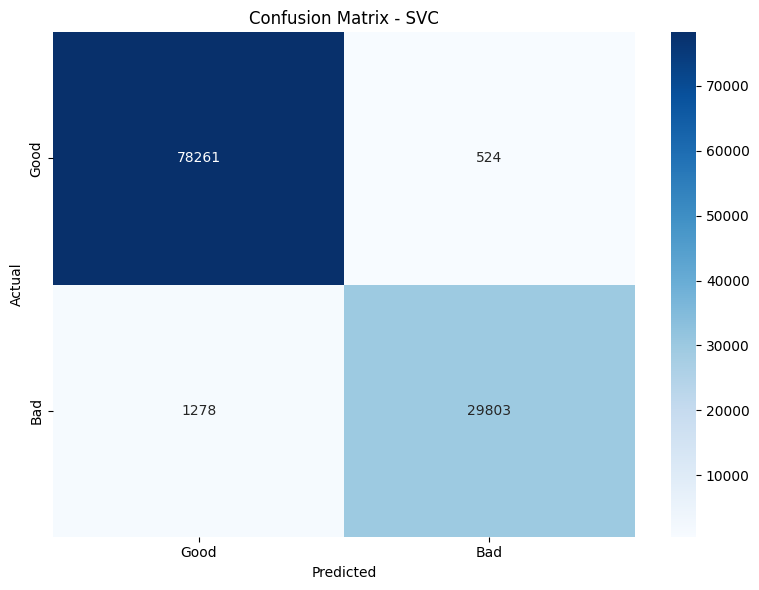

In [ ]:
results("SVC" , svc_clf)


===== Logistic Regression =====
🔍 Model Accuracy: 0.963

📊 Classification Report:
              precision    recall  f1-score   support

    Good (0)       0.96      0.99      0.97     78785
     Bad (1)       0.97      0.89      0.93     31081

    accuracy                           0.96    109866
   macro avg       0.97      0.94      0.95    109866
weighted avg       0.96      0.96      0.96    109866


✅ Real Label Distribution: {0: np.int64(78785), 1: np.int64(31081)}
✅ Predicted Label Distribution: {0: np.int64(81336), 1: np.int64(28530)}


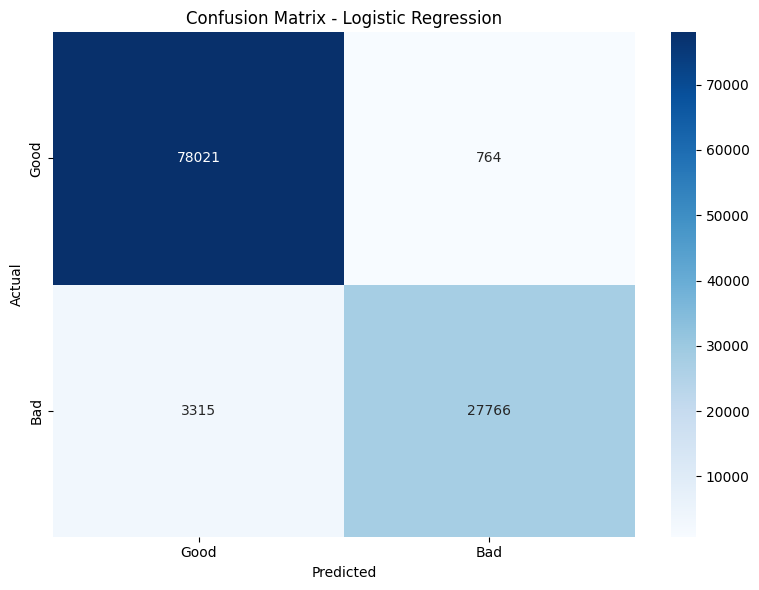

In [ ]:
results("Logistic Regression" , log_clf)


===== Naive Bayes =====
🔍 Model Accuracy: 0.972

📊 Classification Report:
              precision    recall  f1-score   support

    Good (0)       0.98      0.99      0.98     78785
     Bad (1)       0.96      0.94      0.95     31081

    accuracy                           0.97    109866
   macro avg       0.97      0.96      0.97    109866
weighted avg       0.97      0.97      0.97    109866


✅ Real Label Distribution: {0: np.int64(78785), 1: np.int64(31081)}
✅ Predicted Label Distribution: {0: np.int64(79561), 1: np.int64(30305)}


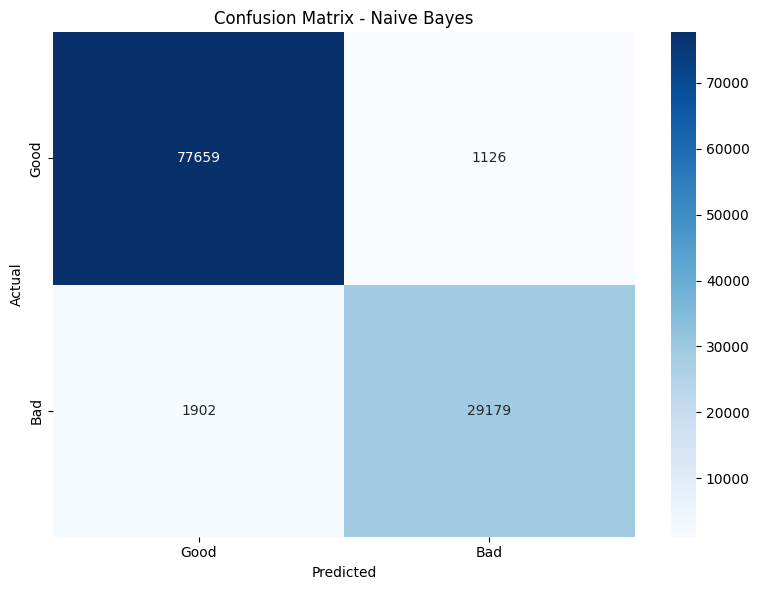

In [ ]:
results("Naive Bayes" , nb_clf)

As we see the SVC performs best out of the three followed by MultinomialNB. While Logistic Regression performs the worst, we can see it produces less false negatives than Naive Bayes.

Also if numerical features are removed, logistic regression performs better. I wouldn't know why this would be the case and would be interested to hear some ideas for it.

# Predict raw url

In [ ]:
import pandas as pd
import random
import tldextract
import re
from urllib.parse import urlparse
from nltk.tokenize import RegexpTokenizer
import joblib
from sklearn.pipeline import Pipeline
from tabulate import tabulate


# === Function: Predict phishing probability of a URL and optionally print the output === #
def predict_url_phishing_proba(url: str, model: Pipeline, show_output: bool = True) -> float:
    parsed = urlparse(url if url.startswith('http') else 'http://' + url)
    netloc = parsed.netloc
    path = parsed.path

    if not netloc:
        raise ValueError("❌ Invalid URL: missing domain part.")

    extract = tldextract.extract(netloc)
    tokenizer = RegexpTokenizer(r'[A-Za-z]+')

    sample = {
        'length': len(url),
        'tld': extract.suffix or 'None',
        'is_ip': bool(re.fullmatch(r"\d+\.\d+\.\d+\.\d+", netloc)),
        'domain_hyphens': netloc.count('-'),
        'domain_underscores': netloc.count('_'),
        'path_hyphens': path.count('-'),
        'path_underscores': path.count('_'),
        'slashes': path.count('/'),
        'full_stops': path.count('.'),
        'num_subdomains': extract.subdomain.count('.') + 1 if extract.subdomain else 0,
        'domain_tokens': " ".join(tokenizer.tokenize(f"{extract.subdomain}.{extract.domain}")),
        'path_tokens': " ".join(tokenizer.tokenize(path)),
    }

    df = pd.DataFrame([sample])

    if hasattr(model.named_steps['classifier'], 'predict_proba'):
        proba = model.predict_proba(df)[0][1]
    else:
        raise ValueError("The current model does not support probability prediction (e.g., LinearSVC)")

    if show_output:
        print("=" * 60)
        print(f"🔍 Scanning URL:\n  {url}")
        print("-" * 60)
        print(f"⚠️  Phishing Probability: {proba:.3f}")

        if proba >= 0.9:
            print("🟥 Risk Level: Extremely High Risk! (Block Recommended)")
        elif proba >= 0.7:
            print("🟧 Risk Level: High Risk (Caution Advised)")
        elif proba >= 0.4:
            print("🟨 Risk Level: Moderate Risk (Manual Review Needed)")
        else:
            print("🟩 Risk Level: Low Risk (Likely Safe Website)")
        print("=" * 60)

    return proba

In [ ]:
# === Step 1: Read the CSV file === #
df_raw = pd.read_csv('./phishing_site_urls.csv')
df_raw = df_raw.rename(columns={'URL': 'url', 'Label': 'label'})

# === Step 2: Randomly sample 10 good and 10 bad examples === #
df_sampled = pd.concat([
    df_raw[df_raw['label'] == 'good'].sample(10, random_state=42),
    df_raw[df_raw['label'] == 'bad'].sample(10, random_state=42)
]).reset_index(drop=True)

# === Step 3: Map labels to numeric values (optional) === #
label_map = {'good': 0, 'bad': 1}
df_sampled['label_num'] = df_sampled['label'].map(label_map)

# === Step 4: Load the trained model === #
model = joblib.load('nb_pipeline_model.pkl')  # Replace with your model file

# === Step 5: Predict in batch and prepare results table === #
results_list = []

for i, row in df_sampled.iterrows():
    url = row['url']
    label = row['label']
    proba = predict_url_phishing_proba(url, model, show_output=False)

    # Determine risk level
    if proba >= 0.9:
        risk = "🟥 Very High"
    elif proba >= 0.7:
        risk = "🟧 High"
    elif proba >= 0.4:
        risk = "🟨 Medium"
    else:
        risk = "🟩 Low"

    results_list.append([
        f"{i+1:02d}",
        url[:50] + ("..." if len(url) > 50 else ""),
        label,
        f"{proba:.3f}",
        risk
    ])

# === Step 6: Print results table === #
headers = ["#", "URL", "True Label", "Phishing Probability", "Risk Level"]
print(tabulate(results_list, headers=headers, tablefmt="fancy_grid"))

╒═════╤═══════════════════════════════════════════════════════╤══════════════╤════════════════════════╤══════════════╕
│   # │ URL                                                   │ True Label   │   Phishing Probability │ Risk Level   │
╞═════╪═══════════════════════════════════════════════════════╪══════════════╪════════════════════════╪══════════════╡
│  01 │ depositaccounts.com/savings/                          │ good         │                  0.028 │ 🟩 Low       │
├─────┼───────────────────────────────────────────────────────┼──────────────┼────────────────────────┼──────────────┤
│  02 │ citypages.com/related/to/Dave+Simonett/               │ good         │                  0.001 │ 🟩 Low       │
├─────┼───────────────────────────────────────────────────────┼──────────────┼────────────────────────┼──────────────┤
│  03 │ askart.com/askart/c/kate_carew/kate_carew.aspx        │ good         │                  0     │ 🟩 Low       │
├─────┼────────────────────────────────────────────

# Feature Importance


🔍 Top 20 Important Features (Linear SVM):
                 feature  coefficient  abs_value
4       path_underscores    -7.003604   7.003604
6             full_stops     5.709312   5.709312
3           path_hyphens    -5.357024   5.357024
7         num_subdomains     4.845915   4.845915
0                 length     3.681282   3.681282
238954            paypal     3.663660   3.663660
205057          includes     3.358256   3.358256
187332               exe     3.327355   3.327355
41384               enci    -3.248245   3.248245
181545           dropbox     3.121045   3.121045
249058             remax     3.112957   3.112957
98802             paypal     2.929426   2.929426
277553            webscr     2.915959   2.915959
228285           mtbtlvu     2.866016   2.866016
108010               rel     2.805543   2.805543
149056             admin     2.754702   2.754702
204688            images     2.704249   2.704249
234023              nwww     2.700519   2.700519
255452            secure  

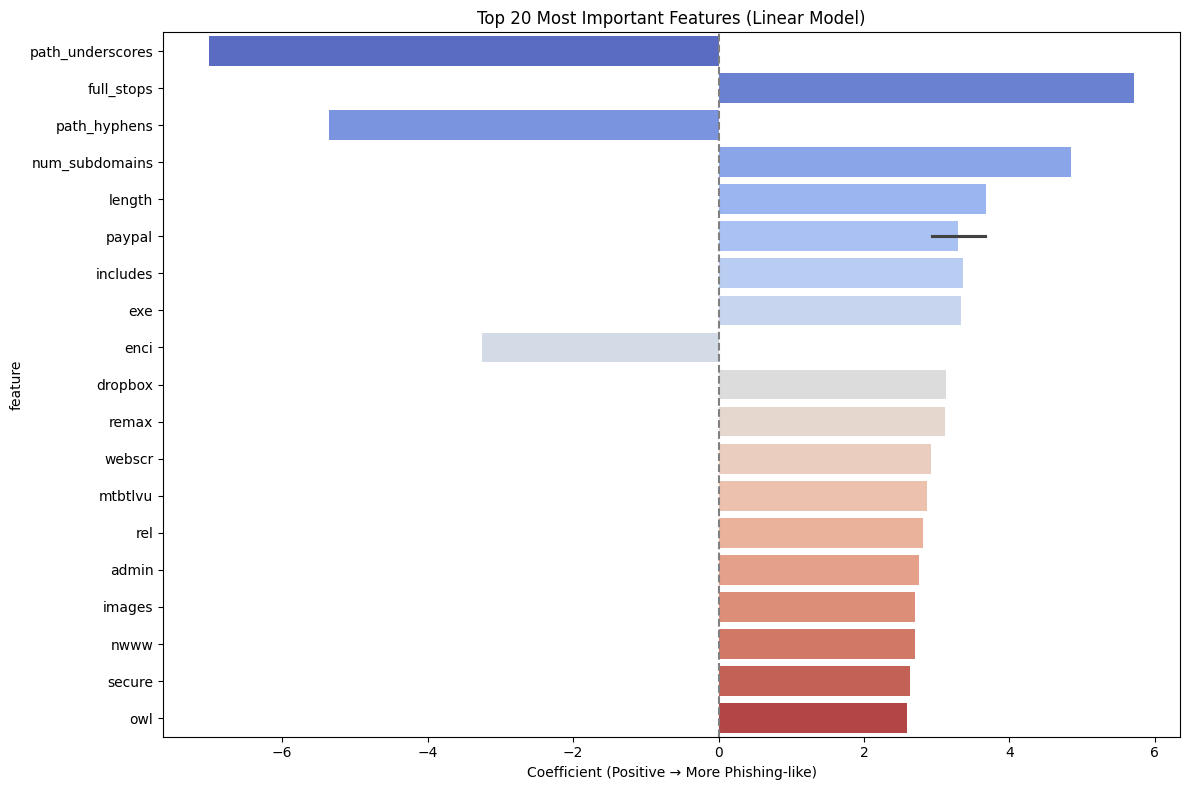

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: 生成全部特征名 === #
onehot_columns = list(
    svc_clf.named_steps['preprocessor']
           .named_transformers_['cat']
           .named_steps['onehot']
           .get_feature_names_out(categorical_features)
)

domvect_columns = list(
    svc_clf.named_steps['preprocessor']
           .named_transformers_['domvec']
           .named_steps['tf']
           .get_feature_names_out()
)

pathvect_columns = list(
    svc_clf.named_steps['preprocessor']
           .named_transformers_['pathvec']
           .named_steps['tf']
           .get_feature_names_out()
)

# 合并所有特征名
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)
numeric_features_list.extend(domvect_columns)
numeric_features_list.extend(pathvect_columns)

# === Step 2: 提取系数（模型必须是 Linear 模型，如 LinearSVC / LogisticRegression）=== #
coef = svc_clf.named_steps['classifier'].coef_.flatten()

# === Step 3: 构建 DataFrame === #
importance_df = pd.DataFrame({
    'feature': numeric_features_list,
    'coefficient': coef,
    'abs_value': np.abs(coef)
})

# === Step 4: 取 Top 20 特征 === #
importance_df = importance_df.sort_values(by='abs_value', ascending=False)
top_n = 20
top_features = importance_df.head(top_n)

# ✅ 打印文本版特征重要性
print("\n🔍 Top 20 Important Features (Linear SVM):")
print(top_features[['feature', 'coefficient', 'abs_value']])

# === Step 5: 可视化条形图 === #
plt.figure(figsize=(12, 8))
sns.barplot(data=top_features, x='coefficient', y='feature', palette='coolwarm')

plt.title(f"Top {top_n} Most Important Features (Linear Model)")
plt.xlabel("Coefficient (Positive → More Phishing-like)")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()


🔍 Top 20 Important Features (Logistic Regression):
                 feature  coefficient  abs_value
3           path_hyphens   -17.544489  17.544489
4       path_underscores   -16.050684  16.050684
0                 length    15.865637  15.865637
6             full_stops    10.717384  10.717384
279952                wp    10.395628  10.395628
204688            images     9.339125   9.339125
238954            paypal     9.178086   9.178086
100453       photobucket    -8.422558   8.422558
7         num_subdomains     8.167459   8.167459
249058             remax     8.113466   8.113466
108010               rel     8.104742   8.104742
187332               exe     8.038498   8.038498
234023              nwww     7.863837   7.863837
205057          includes     7.815607   7.815607
277553            webscr     7.495136   7.495136
218741             login     7.449647   7.449647
242066           plugins     7.427361   7.427361
131776          torrentz    -7.382146   7.382146
181545           

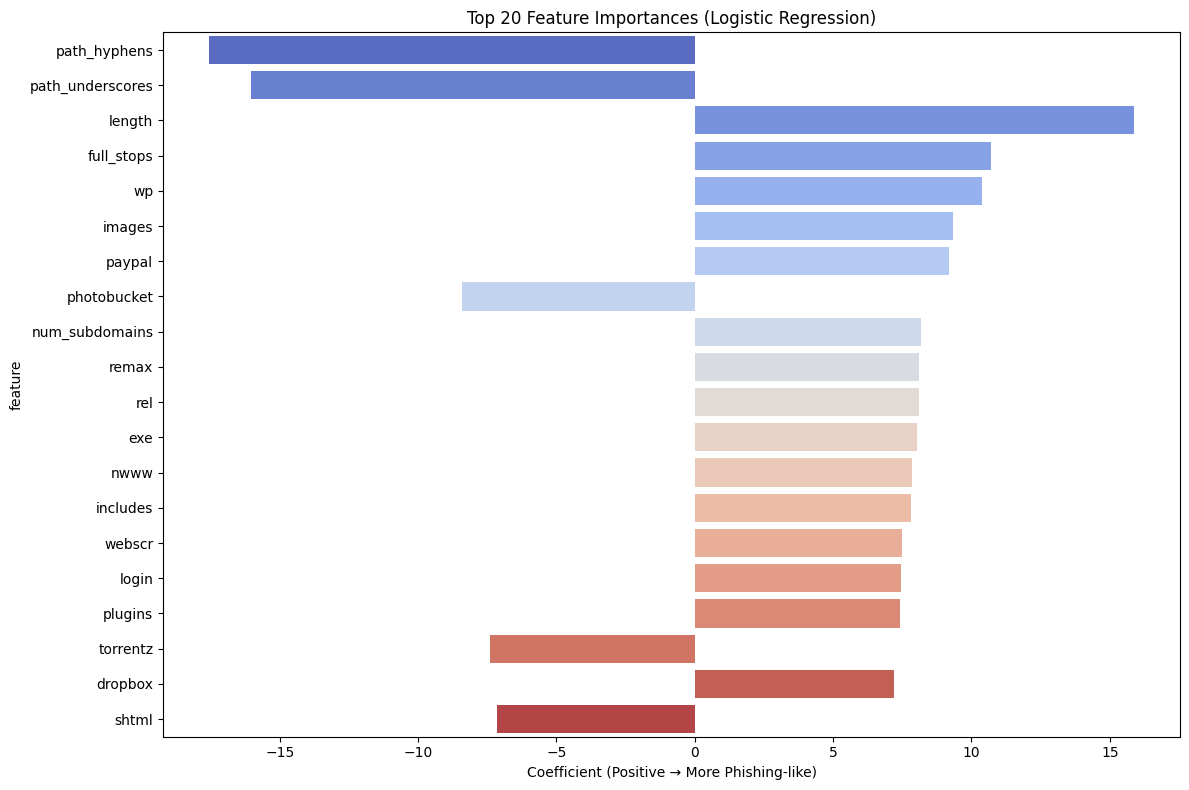

In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load saved pipeline
log_clf = joblib.load('logreg_pipeline_model.pkl')

# Step 2: Access preprocessor and classifier
preprocessor = log_clf.named_steps['preprocessor']
classifier = log_clf.named_steps['classifier']

# Step 3: Define feature groups (must match your original training script)
numeric_features = ['length', 'domain_hyphens', 'domain_underscores',
                    'path_hyphens', 'path_underscores', 'slashes',
                    'full_stops', 'num_subdomains']
categorical_features = ['tld', 'is_ip']

# Step 4: Extract all feature names from preprocessor
num_feats = numeric_features

# Get OneHotEncoder feature names
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feats = ohe.get_feature_names_out(categorical_features)

# Get TF-IDF features
domvec_feats = preprocessor.named_transformers_['domvec'].named_steps['tf'].get_feature_names_out()
pathvec_feats = preprocessor.named_transformers_['pathvec'].named_steps['tf'].get_feature_names_out()

# Combine all
all_feature_names = np.concatenate([num_feats, cat_feats, domvec_feats, pathvec_feats])

# Step 5: Get logistic regression coefficients
coefs = classifier.coef_.flatten()

# Step 6: Create DataFrame and sort
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefs,
    'abs_value': np.abs(coefs)
}).sort_values(by='abs_value', ascending=False)

# Step 7: Display top 20
print("\n🔍 Top 20 Important Features (Logistic Regression):")
print(importance_df.head(20))

# Optional: Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='coefficient', y='feature', palette='coolwarm')
plt.title("Top 20 Feature Importances (Logistic Regression)")
plt.xlabel("Coefficient (Positive → More Phishing-like)")
plt.tight_layout()
plt.show()


🔍 Top 20 Important Features (Naive Bayes):
                  feature  importance  abs_value
142410          wikipedia   -8.243655   8.243655
238954             paypal    8.118308   8.118308
146059            youtube   -7.849564   7.849564
277553             webscr    7.767124   7.767124
98802              paypal    7.733366   7.733366
98395           pastehtml    7.375920   7.375920
262182  stickamcomlogindo    7.353945   7.353945
53388        googlegroups    7.291315   7.291315
181545            dropbox    7.281581   7.281581
62171                imdb   -7.231230   7.231230
88337                 mxp    7.209911   7.209911
733               tld_top    7.123988   7.123988
7081              answers   -7.069974   7.069974
89005             myspace   -7.056470   7.056470
77130               login    7.047069   7.047069
789               tld_xyz    6.959452   6.959452
168691        checkupdate    6.953666   6.953666
658                tld_pw    6.932160   6.932160
61509                ietf

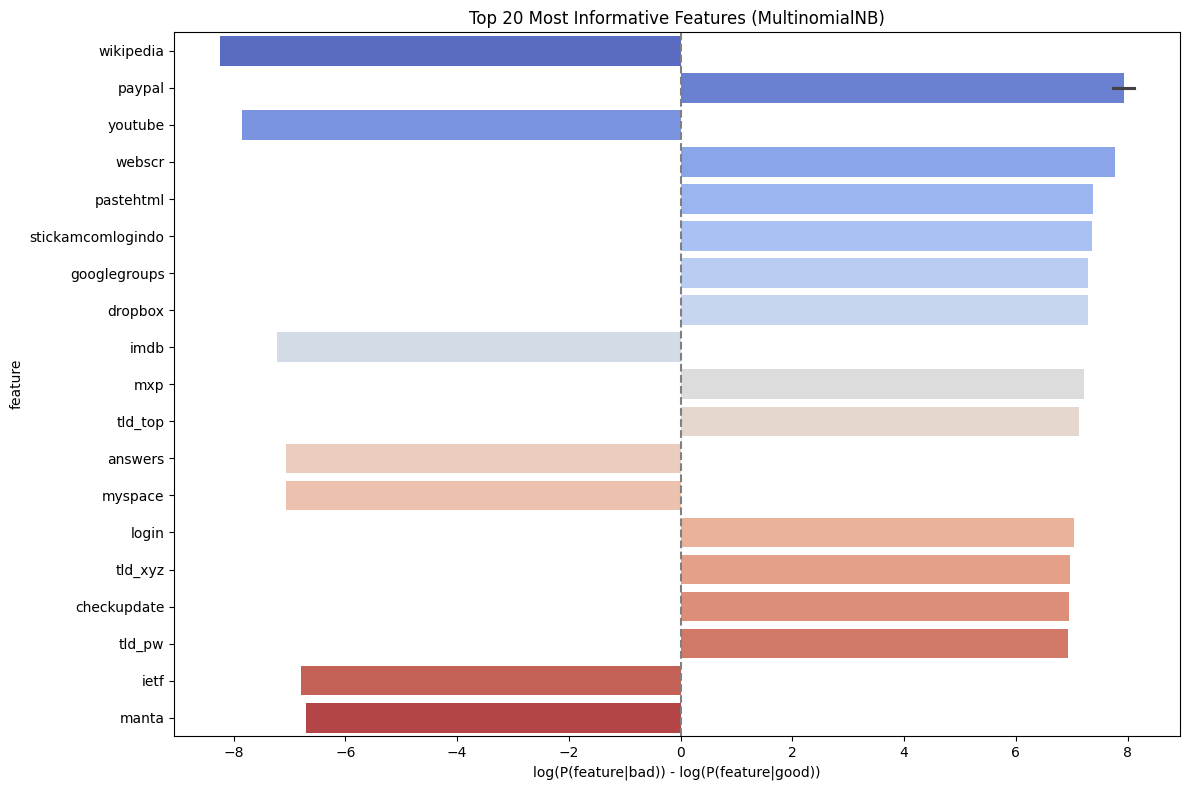

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: 提取所有特征名（和之前一致）
onehot_columns = list(
    nb_clf.named_steps['preprocessor']
          .named_transformers_['cat']
          .named_steps['onehot']
          .get_feature_names_out(categorical_features)
)

domvect_columns = list(
    nb_clf.named_steps['preprocessor']
          .named_transformers_['domvec']
          .named_steps['tf']
          .get_feature_names_out()
)

pathvect_columns = list(
    nb_clf.named_steps['preprocessor']
          .named_transformers_['pathvec']
          .named_steps['tf']
          .get_feature_names_out()
)

numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)
numeric_features_list.extend(domvect_columns)
numeric_features_list.extend(pathvect_columns)

# Step 2: 获取特征对数概率
log_probs = nb_clf.named_steps['classifier'].feature_log_prob_
log_prob_good = log_probs[0]
log_prob_bad = log_probs[1]

# Step 3: 计算差异作为重要性（bad - good）
importance = log_prob_bad - log_prob_good

# Step 4: 构建 DataFrame
importance_df = pd.DataFrame({
    'feature': numeric_features_list,
    'importance': importance,
    'abs_value': np.abs(importance)
}).sort_values(by='abs_value', ascending=False)

# Step 5: 打印前 20
top_n = 20
top_features = importance_df.head(top_n)

print("\n🔍 Top 20 Important Features (Naive Bayes):")
print(top_features[['feature', 'importance', 'abs_value']])

# Step 6: 可视化
plt.figure(figsize=(12, 8))
sns.barplot(data=top_features, x='importance', y='feature', palette='coolwarm')
plt.title(f"Top {top_n} Most Informative Features (MultinomialNB)")
plt.xlabel("log(P(feature|bad)) - log(P(feature|good))")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_feature_names_from_pipeline(pipeline, numeric_features, categorical_features):
    onehot_columns = list(
        pipeline.named_steps['preprocessor']
                .named_transformers_['cat']
                .named_steps['onehot']
                .get_feature_names_out(categorical_features)
    )

    domvect_columns = list(
        pipeline.named_steps['preprocessor']
                .named_transformers_['domvec']
                .named_steps['tf']
                .get_feature_names_out()
    )

    pathvect_columns = list(
        pipeline.named_steps['preprocessor']
                .named_transformers_['pathvec']
                .named_steps['tf']
                .get_feature_names_out()
    )

    all_features = list(numeric_features) + onehot_columns + list(domvect_columns) + list(pathvect_columns)
    return all_features


def get_logreg_coeffs(pipeline, feature_names):
    coefs = pipeline.named_steps['classifier'].coef_.flatten()
    return pd.Series(coefs, index=feature_names, name='LogisticRegression')


def get_svc_coeffs(pipeline, feature_names):
    coefs = pipeline.named_steps['classifier'].coef_.flatten()
    return pd.Series(coefs, index=feature_names, name='LinearSVC')


def get_nb_diffs(pipeline, feature_names):
    log_probs = pipeline.named_steps['classifier'].feature_log_prob_
    importance = log_probs[1] - log_probs[0]  # bad - good
    return pd.Series(importance, index=feature_names, name='NaiveBayes')


def plot_model_comparison(logreg_model, svc_model, nb_model, numeric_features, categorical_features, top_n=20):
    feature_names = get_feature_names_from_pipeline(logreg_model, numeric_features, categorical_features)

    logreg_importance = get_logreg_coeffs(logreg_model, feature_names)
    svc_importance = get_svc_coeffs(svc_model, feature_names)
    nb_importance = get_nb_diffs(nb_model, feature_names)

    # Combine into single DataFrame
    df_all = pd.concat([logreg_importance, svc_importance, nb_importance], axis=1)
    df_all['abs_mean'] = df_all.abs().mean(axis=1)
    df_top = df_all.sort_values(by='abs_mean', ascending=False).head(top_n)

    print("\n Top {} Feature Importance Across Models:".format(top_n))
    print(df_top.drop(columns='abs_mean').round(4))

    # Melt for seaborn
    df_melt = df_top.drop(columns='abs_mean').reset_index().melt(id_vars='index',
                                                                  var_name='Model',
                                                                  value_name='Importance')
    df_melt.rename(columns={'index': 'Feature'}, inplace=True)

    plt.figure(figsize=(14, 10))
    sns.barplot(data=df_melt, x='Importance', y='Feature', hue='Model', palette='Set1', ci=None)
    plt.title(f' Top {top_n} Feature Importance Comparison Across Models')
    plt.axvline(0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()

# 新段落


 Top 20 Feature Importance Across Models:
                  LogisticRegression  LinearSVC  NaiveBayes
path_hyphens                -17.5445    -5.3570     -1.7590
path_underscores            -16.0507    -7.0036     -1.3354
paypal                        9.1781     3.6637      8.1183
length                       15.8656     3.6813      0.1167
webscr                        7.4951     2.9160      7.7671
wp                           10.3956     2.5332      4.9678
includes                      7.8156     3.3583      6.5814
dropbox                       7.1865     3.1210      7.2816
remax                         8.1135     3.1130      6.2189
exe                           8.0385     3.3274      5.5240
nwww                          7.8638     2.7005      6.2688
paypal                        6.1434     2.9294      7.7334
full_stops                   10.7174     5.7093     -0.2825
rel                           8.1047     2.8055      5.4217
images                        9.3391     2.7042      4.19

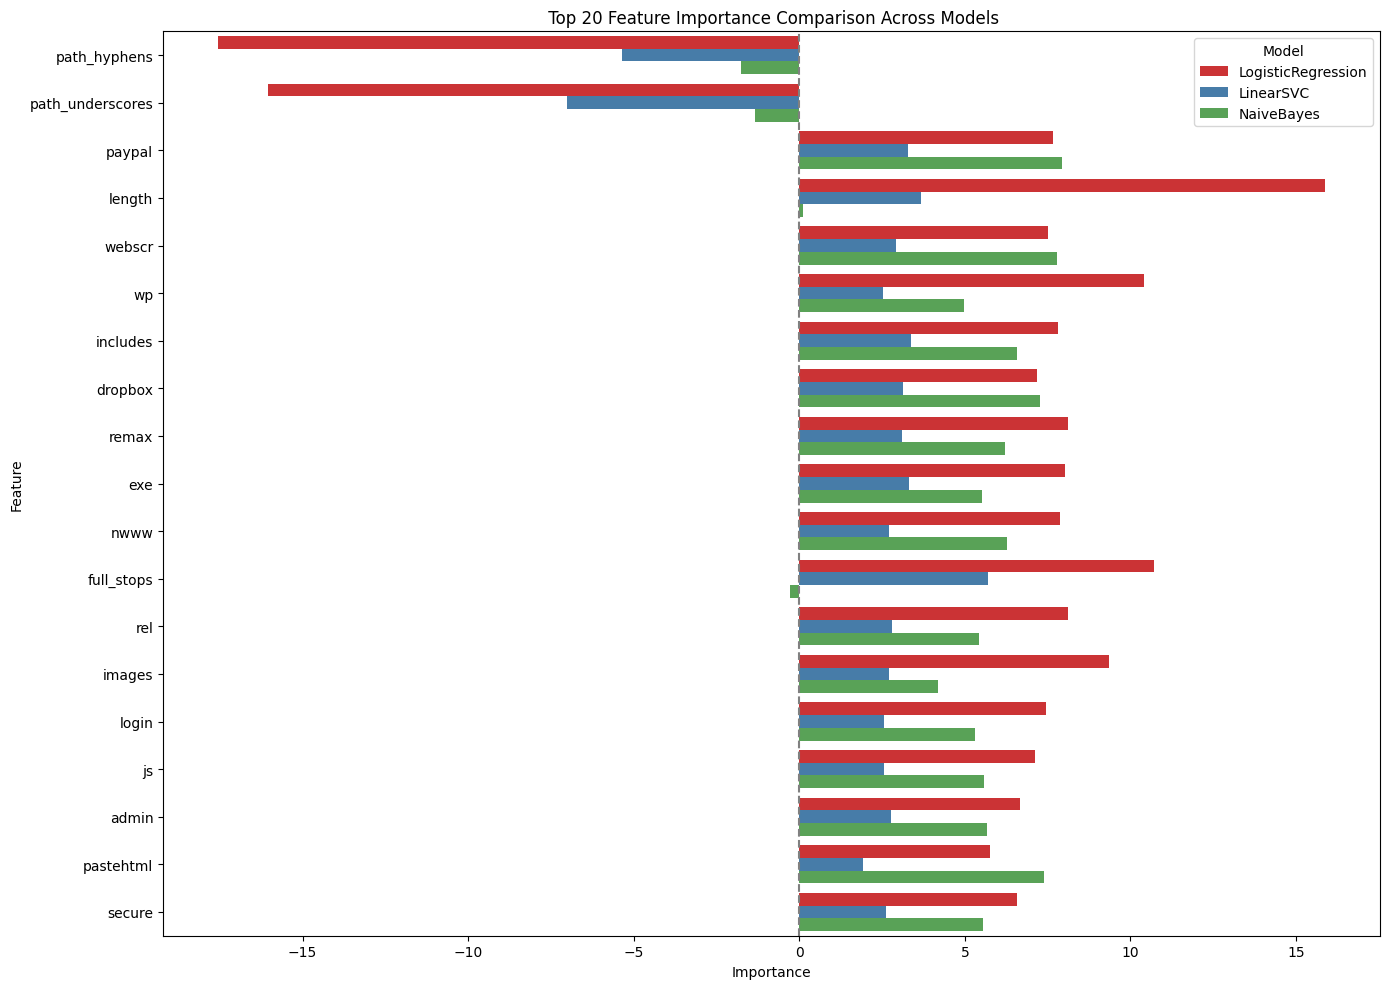

In [ ]:
plot_model_comparison(log_clf, svc_clf, nb_clf, numeric_features, categorical_features, top_n=20)